In [1]:
import sys
sys.path.append('../code')
import torch as t 
import torch.nn.functional as F
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from sklearn.decomposition import PCA

%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [2]:
start_num = 10 
total_iteration_num= 20000
exp_num = '3'

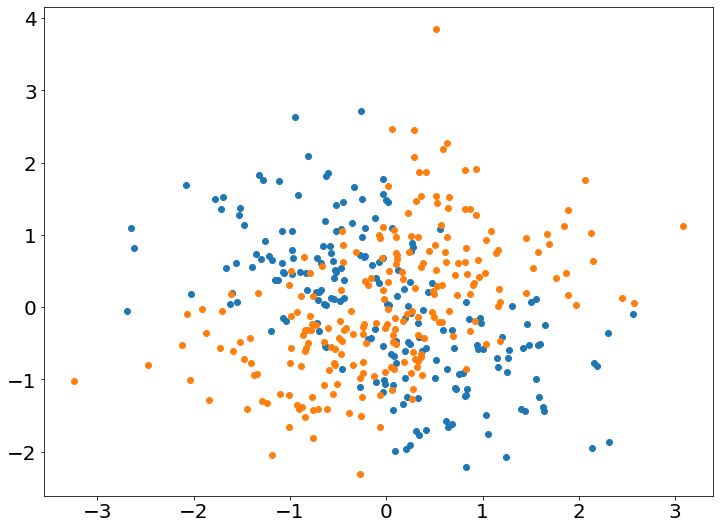

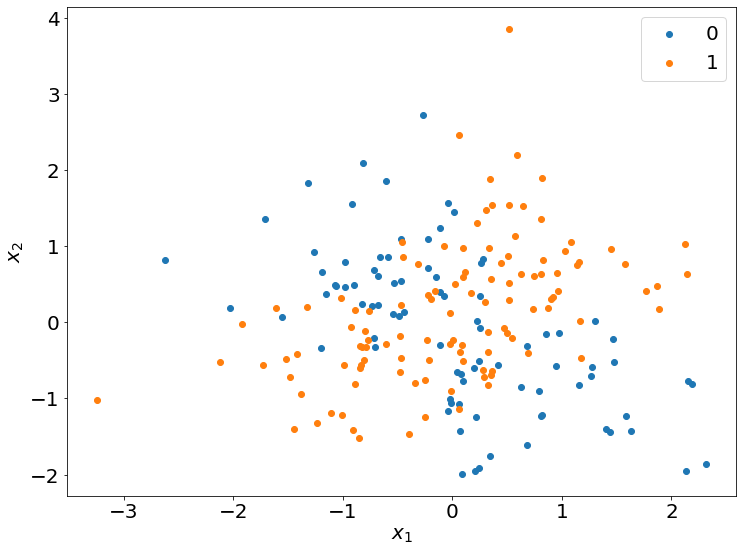

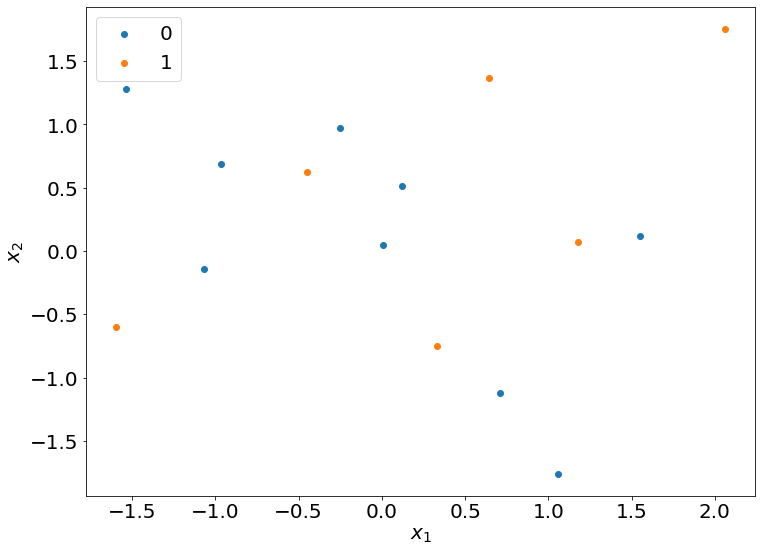

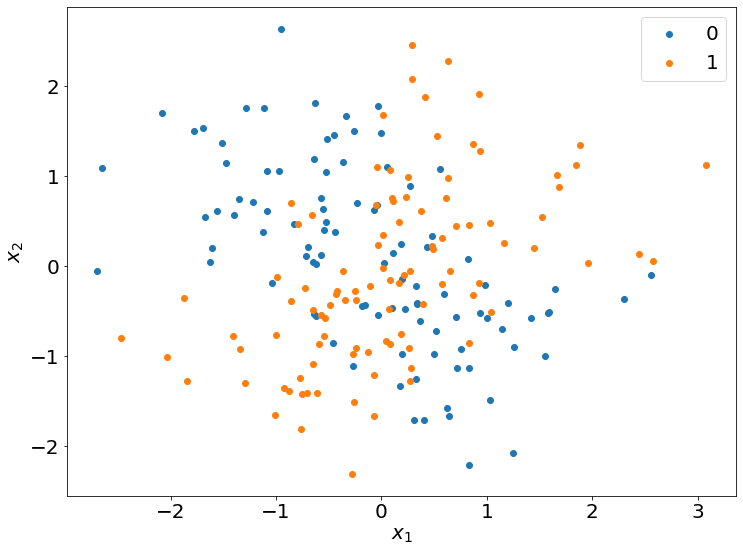

In [3]:
np.random.seed(42)
teacher_train_size, student_train_size, student_validation_size, test_size = 200, 15, 15, 200
total_size =  sum([teacher_train_size, student_train_size, student_validation_size, test_size])
eps = .5
"""
Y генерируется как:
    sign (x1 * x2) + шум
    
Признаки для учителя:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак коррелирует с Y, но не покрывает его
    
Признаки для ученика:
    x1; x2; индикатор, что x1 >0 и x2>0 
    Последний признак отличается от Y из-за шума
        
    
"""
# полные данные
x_big = np.random.randn(total_size, 2)
y_big = (np.sign(x_big[:,0]*x_big[:,1]+np.random.randn(total_size)*eps)+1)//2
x_big = np.vstack([x_big[:,0], x_big[:,1],  (np.sign(x_big[:,0])+np.sign(x_big[:,1]) >0.1)*1.0, 
                   x_big[:,0]*x_big[:,1]]).T

# обучение учителя. NB: не пересекается с выборкой для обучения ученика, так проще подобрать параметры
x_ttrain = t.tensor(x_big[:teacher_train_size], dtype=t.float32)
y_ttrain = t.tensor(y_big[:teacher_train_size], dtype=t.long)


# обучение ученика
x_train = t.tensor(x_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.float32)
y_train = t.tensor(y_big[teacher_train_size:teacher_train_size+student_train_size], dtype=t.long)

# валидация, в этом ноутбуке не используется
x_val = t.tensor(x_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], 
                 dtype=t.float32)
y_val = t.tensor(y_big[teacher_train_size+student_train_size:teacher_train_size+student_train_size+student_validation_size], dtype=t.long)


x_test = t.tensor(x_big[-test_size:], dtype=t.float32)
y_test = t.tensor(y_big[-test_size:], dtype=t.long)

plt.scatter(x_big[y_big==0,0], x_big[y_big==0,1])
plt.scatter(x_big[y_big==1,0], x_big[y_big==1,1])

plt.show()

plt.scatter(x_ttrain[y_ttrain==0,0], x_ttrain[y_ttrain==0,1], label='0')
plt.scatter(x_ttrain[y_ttrain==1,0], x_ttrain[y_ttrain==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('ttrain.pdf')
plt.legend()
plt.show()

plt.scatter(x_train[y_train==0,0], x_train[y_train==0,1], label='0')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('train.pdf')
plt.legend()
plt.show()

plt.scatter(x_test[y_test==0,0], x_test[y_test==0,1], label='0')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], label='1')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('test.pdf')
plt.legend()
plt.show()


In [4]:
class LogReg(t.nn.Module):
    def __init__(self, idx):
        t.nn.Module.__init__(self)
        self.lin = t.nn.Linear(len(idx), 2) 
        self.idx = idx        
    
    def forward(self, x):
        return self.lin(x[:, self.idx])
    
        

In [5]:
def accuracy(student, x,y):
    student.eval()
    total = 0 
    correct = 0
    with t.no_grad():
        out = student(x)
        correct += t.eq(t.argmax(out, 1), y).sum()
        total+=len(x)
    student.train()
    return (correct/total).cpu().detach().numpy()

In [6]:
# обучение учителя
t.manual_seed(0)
teacher = LogReg([0,1,2])
optim = t.optim.Adam(teacher.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    teacher.zero_grad() 
    loss = crit(teacher(x_ttrain), y_ttrain)
    loss.backward()
    optim.step()    
    
    teacher.eval()
    if e%1000==0:
        print (accuracy(teacher, x_test, y_test ))    
    teacher.train()
    



0.5
0.66
0.665
0.69
0.69
0.69
0.69
0.69
0.69
0.69


In [7]:
# обучение студента без дистилляции
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
for e in range(10000):                                
    student.zero_grad()            
    loss = crit(student(x_train), y_train)
    loss.backward()
    optim.step()        
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    



0.48
0.69
0.725
0.745
0.76
0.755
0.755
0.755
0.755
0.755


In [7]:
kl = t.nn.KLDivLoss(reduction='batchmean')
sm = t.nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = t.nn.functional.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [ ]:
# полная дистилляция
beta1 = 0.0
beta2 = 1.0
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

In [ ]:
# дистилляция с разными коэффициентами
beta1 = 1.0
beta2 = .5
temp = 1.0
student = LogReg([0,1,3])
optim = t.optim.Adam(student.parameters())    
crit = t.nn.CrossEntropyLoss()
teacher.eval()
for e in range(10000):                                
    student.zero_grad()    
    out = student(x_train)
    student_loss = crit(out, y_train)            
    distillation_loss = distill(out, teacher(x_train), temp)
    loss = beta1 * student_loss + beta2*distillation_loss        
    loss.backward()
    optim.step()    
    
    student.eval()
    if e%1000==0:
        print (accuracy(student, x_test, y_test ))    
    student.train()
    

In [9]:
# дистилляция с оптимизацией гиперапарметров

def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 10
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

for _ in range(start_num):
    results_opt = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    optim2 = t.optim.SGD(h,  lr=10e04)   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        
        optim2.zero_grad()            
        hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))
        optim2.step()

        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()  
        student.train()       
        if e%1000==0:
            student.eval()
            print(accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                  float(F.sigmoid(beta2).detach().numpy()), 
                  float(10*F.sigmoid(temp).detach().numpy()))
            student.train()
            results_opt.append([e, 
                                float(accuracy(student, x_test, y_test)),
                                float(F.sigmoid(beta1).detach().numpy()),
                                float(F.sigmoid(beta2).detach().numpy()), 
                                float(10*F.sigmoid(temp).detach().numpy())])
    with open('exp'+exp_num+'_linear_exp_hyper_opt.jsonl','a') as out:
        out.write(json.dumps(results_opt)+'\n')
    
            

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.48 0.5501601696014404 0.5089210271835327 4.597083926200867


KeyboardInterrupt: 

In [ ]:
# дистилляция со сплайнами
# параметр: сколько итераций длится одна эпоха. Обучаемся каждую вторую эпоху
#epoch_size = 10
#epoch_size = 100
#epoch_size = 1000
# epoch_size = 2000




def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = 0.1+F.sigmoid(temp) * 9.9
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

grads = []
for epoch_size in [10, 100, 500, 1000, 2000]:
    # results_opt = []
    for _ in range(start_num):
        results_opt = []
        beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
        beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
        temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
        h = [beta1, beta2, temp]

        student = LogReg([0,1,3])
        optim = t.optim.Adam(student.parameters())    
        optim2 = t.optim.SGD(h, lr=10e4)   
        hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        crit = t.nn.CrossEntropyLoss()
        teacher.eval()
        for e in range(total_iteration_num):
            e_ = e//epoch_size
            if e%epoch_size == 0 and e_ % 2 == 0:
                    spline_hist = []
                    spline_id  = -1 
                    #optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))      
                    #hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
            spline_id+=1
            # если настала пора понаблюдать за траекторий гиперпараметров
            if  e_ % 2 == 0:           
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))                        
                t.nn.utils.clip_grad_value_(h, 1.0)
                for h_ in h:
                    h_.grad = t.where(t.isnan(h_.grad), t.zeros_like(h_.grad), h_.grad)                        
                grads.append([h_.grad.cpu().detach().clone().numpy() for h_ in h])
                spline_hist.append([h_.cpu().detach().clone().numpy() for h_ in h])
                
                optim2.step()
                
                
            else:
                # иначе гиперпараметры предсказываем на основе сплайнов
                # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
                # в которых градиент потом будет нулевым            
                spline_out = splines(spline_id)                
                beta1.data *= 0
                beta2.data *= 0
                temp.data *= 0
                
                beta1.data += spline_out[0]
                beta2.data += spline_out[1]
                temp.data += spline_out[2]
                
            #hist.append([h_.cpu().detach().clone().numpy() for h_ in h])
            

         
            optim.zero_grad()
            out = student(x_train)
            loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
            loss.backward()
            optim.step()  
            student.train()       
            if e%1000==0:
                student.eval()
                if e_ %2 == 0:
                    mode = 'hypertrain'
                else:
                    mode = 'hyperpredict'
                print(mode, accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                      float(F.sigmoid(beta2).detach().numpy()), 
                      float(10*F.sigmoid(temp).detach().numpy()))
                student.train()

                results_opt.append([e, float(accuracy(student, x_test, y_test)), float(F.sigmoid(beta1).detach().numpy()),
                                    float(F.sigmoid(beta2).detach().numpy()), 
                                    float(9.9*F.sigmoid(temp).detach().numpy()+0.1)])
            # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if e_ % 2 == 0 and e%epoch_size == epoch_size-1:
                    fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                    fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                    fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                    splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted3, x)])

        with open('exp'+exp_num+'_linear_exp_splines_epoch_size_{}.jsonl'.format(epoch_size),'a') as out:
            out.write(json.dumps(results_opt)+'\n')

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
<ipython-input-7-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


hypertrain 0.61 0.5063005089759827 0.5893926024436951 1.2802784144878387
hypertrain 0.79 0.08774831146001816 0.9080283045768738 0.0024543641484342515
hypertrain 0.805 0.01243346557021141 0.9395105838775635 0.0023561023408547044
hypertrain 0.815 0.014327761717140675 0.9389660358428955 0.002441385295242071
hypertrain 0.815 0.01433398574590683 0.9389277696609497 0.002547704498283565
hypertrain 0.815 0.014352509751915932 0.9389272332191467 0.002664070052560419
hypertrain 0.815 0.014371524564921856 0.9389272332191467 0.0027919095009565353
hypertrain 0.815 0.014392668381333351 0.9389272332191467 0.002932447532657534
hypertrain 0.815 0.014416191726922989 0.9389272332191467 0.003088090743403882


tensor(0.)

In [37]:
spline_hist 

[[array(0.5821851, dtype=float32),
  array(1.4030489, dtype=float32),
  array(-5.406391, dtype=float32)],
 [array(0.65458494, dtype=float32),
  array(1.4045131, dtype=float32),
  array(-5.718439, dtype=float32)],
 [array(0.77027845, dtype=float32),
  array(1.4059646, dtype=float32),
  array(-6.08993, dtype=float32)],
 [array(0.95186114, dtype=float32),
  array(1.4074025, dtype=float32),
  array(-6.5005407, dtype=float32)],
 [array(1.3471036, dtype=float32),
  array(1.4088256, dtype=float32),
  array(-8.285566, dtype=float32)],
 [array(9.504499, dtype=float32),
  array(1.4102318, dtype=float32),
  array(-56.862457, dtype=float32)]]

In [31]:
spline_hist

[[array(3.223239, dtype=float32),
  array(4.6178255, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.617797, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.6177683, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.6177397, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.617711, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.617682, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.617653, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.617624, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.6175947, dtype=float32),
  array(-20.837374, dtype=float32)],
 [array(3.223239, dtype=float32),
  array(4.6175656

In [ ]:
# дистилляция со сплайнами
# параметр: раз в сколько эпох мы обучаем сплайны

# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 5
#train_splines_every_epoch = 10
epoch_size = 10 # !!! размер эпохи нужно подобрать экспериментом выше


def param_loss(batch,model,h):
    x,y,batch_logits = batch    
    beta,beta2,temp = h
    out = model(x)
    beta = F.sigmoid(beta)
    beta2 = F.sigmoid(beta2)
    temp = F.sigmoid(temp) * 9.9 + 0.1
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)                
    loss = beta * distillation_loss + beta2 * student_loss
    return loss

def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

for train_splines_every_epoch in [2,3,5,10]:
    for _ in range(start_num):
        print ('train splines', train_splines_every_epoch)
        results_opt = []

        beta1 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high = 1)), requires_grad=True)
        beta2 = t.nn.Parameter(t.tensor(np.random.uniform(low=-1, high=1)), requires_grad=True)
        temp = t.nn.Parameter(t.tensor(np.random.uniform(low=-2, high=0)), requires_grad=True)
        h = [beta1, beta2, temp]

        student = LogReg([0,1,3])
        optim = t.optim.Adam(student.parameters())    
        optim2 = t.optim.SGD(h, lr=10e4)   
        hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        crit = t.nn.CrossEntropyLoss()
        teacher.eval()
        for e in range(total_iteration_num):
            e_ = e//epoch_size

            if e%epoch_size == 0 and e_ % train_splines_every_epoch == 0:
                    spline_hist = []
                    spline_id  = -1                 
            spline_id+=1
            # если настала пора понаблюдать за траекторий гиперпараметров
            if e_ % train_splines_every_epoch == 0:           
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x_train,y_train,teacher(x_train)), (x_test, y_test))                        
                t.nn.utils.clip_grad_value_(h, 1.0)
                for h_ in h:
                    h_.grad = t.where(t.isnan(h_.grad), t.zeros_like(h_.grad), h_.grad)                                        
                spline_hist.append([h_.cpu().detach().clone().numpy() for h_ in h])
                
                optim2.step()
            else:
                # иначе гиперпараметры предсказываем на основе сплайнов
                # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
                # в которых градиент потом будет нулевым            
                spline_out = splines(spline_id)                
                beta1.data *= 0
                beta2.data *= 0
                temp.data *= 0
                
                beta1.data += spline_out[0]
                beta2.data += spline_out[1]
                temp.data += spline_out[2]
                

            optim.zero_grad()
            out = student(x_train)
            loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
            loss.backward()
            optim.step()  
            student.train()       
            if e%1000==0:
                student.eval()
                if e_ % train_splines_every_epoch == 0:
                    mode = 'hypertrain'
                else:
                    mode = 'hyperpredict'
                print(mode, accuracy(student, x_test, y_test), float(F.sigmoid(beta1).detach().numpy()), 
                      float(F.sigmoid(beta2).detach().numpy()), 
                      float(10*F.sigmoid(temp).detach().numpy()))
                student.train()

                results_opt.append([e, float(accuracy(student, x_test, y_test)), float(F.sigmoid(beta1).detach().numpy()),
                                    float(F.sigmoid(beta2).detach().numpy()), 
                                    float(0.1+9.9*F.sigmoid(temp).detach().numpy())])

            # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
            if e_ % train_splines_every_epoch == 0 and e%epoch_size == epoch_size-1:
                    fitted1 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,0], 1)
                    fitted2 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,1], 1)
                    fitted3 = np.polyfit(range(len(spline_hist)), np.array(spline_hist)[:,2], 1)
                    splines = lambda x : np.array([np.polyval(fitted1, x), np.polyval(fitted2, x), np.polyval(fitted3, x)])
        with open('exp'+exp_num+'_linear_exp_splines_train_every_{}.jsonl'.format(train_splines_every_epoch),'a') as out:
            out.write(json.dumps(results_opt)+'\n')

In [84]:
# дистилляция со случайными гиперпараметрами
# NB: здесь оставляем такую же инициализацию параметров, что и раньше! 
# это так задумано

def param_loss(batch,model,h):
    x,y,batch_logits = batch
    #beta,temp = h
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99)
    beta2 = t.clamp(beta2, 0.01, 0.99)
    temp = t.clamp(temp, 0.1, 10.0)
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    #loss = (1-beta) * student_loss + beta*distillation_loss
    loss = beta * distillation_loss + beta2 * student_loss
    return loss
for _ in range(start_num):
    results_rand = []
    results_rand_param = []

    beta1 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform()), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1)), requires_grad=True)
    h = [beta1, beta2, temp]

    student = LogReg([0,1,3])
    optim = t.optim.Adam(student.parameters())    
    crit = t.nn.CrossEntropyLoss()
    teacher.eval()
    for e in range(total_iteration_num):
        optim.zero_grad()
        out = student(x_train)
        loss = param_loss((x_train,y_train,teacher(x_train)), student,h)
        loss.backward()
        optim.step()    

        if e%1000==0:
            student.eval()
            print(accuracy(student, x_test, y_test), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy()))
            student.train()
            results_rand.append([e, float(accuracy(student, x_test, y_test)), float(beta1.detach().numpy()), float(beta2.detach().numpy()), float(temp.detach().numpy())])
            par = [p.detach().numpy().flatten() for p in student.parameters()]
            results_rand_param.append(np.concatenate((par[0], par[1])))
    with open('exp'+exp_num+'_linear_exp_random.jsonl','a') as out:
        out.write(json.dumps(results_rand)+'\n')

<ipython-input-8-8c26b1136af2>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = t.nn.functional.log_softmax(batch_logits/temp)


0.615 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.76 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.6638075113296509
0.77 0.3945760726928711 0.42182818055152893 0.66380751

0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.785 0.3838388919830322 0.45623651146888733 0.5471495389938354
0.515 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.71 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.75 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.765 0.12102500349283218 0.4189477860927582 3.1794800758361816
0.765 0.12102500349283218 0.41894778609275

In [8]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [ ]:
num = 0
for res in res_opt_full:
    num+=1
    pca = PCA(n_components=2)
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label=str(num))
    plt.scatter(par[0, 0],par[0, 1], color='black')
    
plt.title('Дистилляция с оптимизацией\n гиперпараметров')    
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
#plt.legend()
plt.savefig('plot_params_opt.pdf')
#plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))#=(5, 5))
ax = fig.add_subplot(111, projection='3d')

for res in res_opt_full:
    temp = np.array(res)[:, 4]
    beta1 = np.array(res)[:, 2]
    beta2 = np.array(res)[:, 3]
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    ax.plot(beta1, beta2, temp, marker='.', label='оптимизация гипепараметров')
    ax.scatter(beta1[0], beta2[0], temp[0], color='black')
    
ax.set_xlabel('beta1')
ax.set_ylabel('beta2')
ax.set_zlabel('$T_0$')
#plt.legend()
plt.show()
plt.savefig('plot_beta_temp3.pdf')

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [ ]:
pca = PCA(n_components=2)
for res in res_full:
    par = pca.fit_transform(res)
    # for i in range(3):
    #     ax.plot(beta_h[:, i], beta2_h[:, i], temp_h[:, i], label='оптимизация гипепараметров')
    plt.plot(par[:, 0],par[:, 1], marker='.', label='')
    plt.scatter(par[0, 0], par[0, 1], color='black')

    plt.title('Дистилляция со случайными\n значениями гиперпараметров')
    plt.xlabel('$w_1$')
    plt.ylabel('$w_2$')
    #plt.legend()
plt.savefig('plot_params_rand.pdf')
plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

In [28]:
with open("exp3_linear_exp_splines_epoch_size_10.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_epoch_size_100.jsonl", "r") as read_file:
    data_100 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_epoch_size_500.jsonl", "r") as read_file:
    data_500 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_epoch_size_1000.jsonl", "r") as read_file:
    data_1000 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_epoch_size_2000.jsonl", "r") as read_file:
    data_2000 = [json.loads(line) for line in read_file]

In [65]:
data = data_10
#e = np.array([data[0][i][0] for i in range(len(data[0]))])
#acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
acc

array([[0.44      , 0.44499999, 0.53500003, 0.61500001, 0.67000002,
        0.57499999, 0.44999999, 0.31999999, 0.48500001, 0.495     ],
       [0.81      , 0.81999999, 0.745     , 0.75999999, 0.755     ,
        0.75      , 0.495     , 0.75999999, 0.80000001, 0.71499997],
       [0.815     , 0.81      , 0.82499999, 0.81999999, 0.79500002,
        0.81999999, 0.495     , 0.80500001, 0.81      , 0.81      ],
       [0.81999999, 0.81999999, 0.81999999, 0.82499999, 0.815     ,
        0.82499999, 0.495     , 0.82499999, 0.82499999, 0.815     ],
       [0.82499999, 0.82499999, 0.82499999, 0.80500001, 0.82499999,
        0.81      , 0.495     , 0.81999999, 0.82499999, 0.81999999],
       [0.82499999, 0.82499999, 0.82499999, 0.81999999, 0.82499999,
        0.815     , 0.495     , 0.82499999, 0.80000001, 0.82499999],
       [0.82499999, 0.82499999, 0.82499999, 0.82499999, 0.82499999,
        0.815     , 0.495     , 0.82499999, 0.80000001, 0.82499999],
       [0.82499999, 0.82499999, 0.8249999

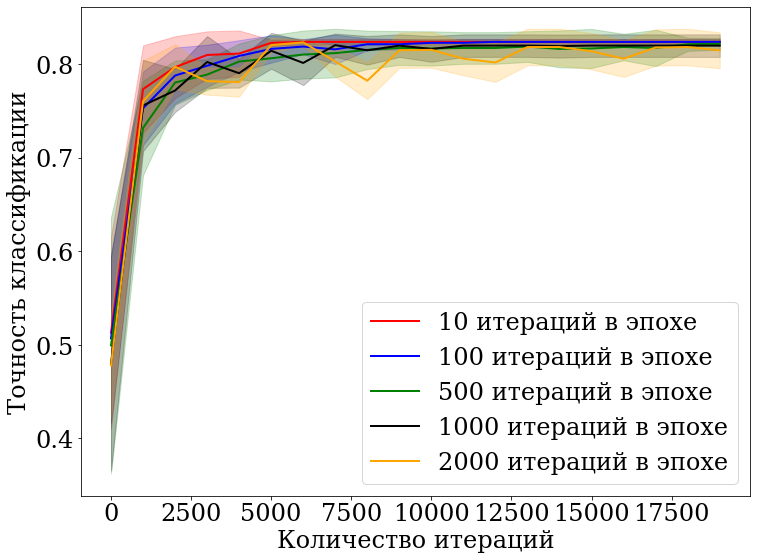

In [29]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_10, '10 итераций в эпохе', 'red')
plot_data(data_100, '100 итераций в эпохе', 'blue')
plot_data(data_500, '500 итераций в эпохе', 'green')
plot_data(data_1000, '1000 итераций в эпохе', 'black')
plot_data(data_2000, '2000 итераций в эпохе', 'orange')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации при различных значениях размера эпохи')
plt.savefig('linear_epoch_size.pdf')
plt.show()

In [30]:
with open("exp3_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_2 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_train_every_3.jsonl", "r") as read_file:
    data_3 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_train_every_5.jsonl", "r") as read_file:
    data_5 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_train_every_10.jsonl", "r") as read_file:
    data_10 = [json.loads(line) for line in read_file]

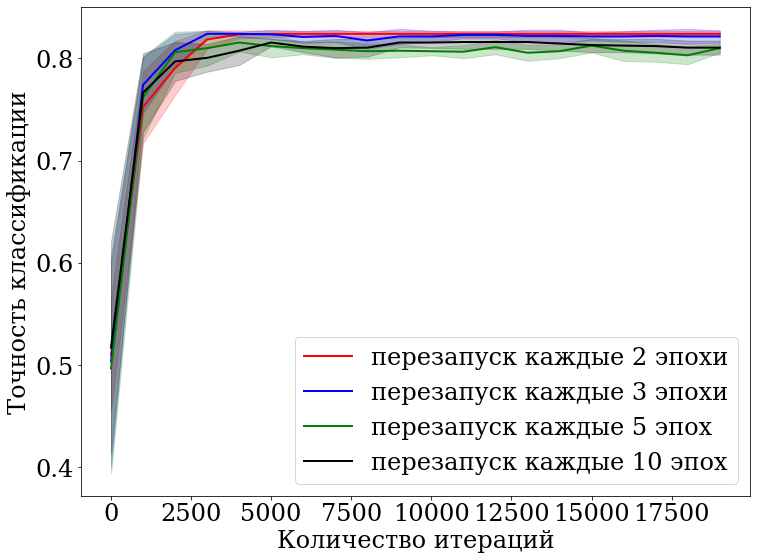

In [31]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_2, 'перезапуск каждые 2 эпохи', 'red')
plot_data(data_3, 'перезапуск каждые 3 эпохи', 'blue')
plot_data(data_5, 'перезапуск каждые 5 эпох', 'green')
plot_data(data_10, 'перезапуск каждые 10 эпох', 'black')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации при различных train_splines_every_epoch')
plt.savefig('linear_train_splines_every_epoch.pdf')
plt.show()

In [32]:
with open("exp3_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_spline = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_hyper_opt.jsonl", "r") as read_file:
    data_opt = [json.loads(line) for line in read_file]
with open("exp2_linear_exp_random.jsonl", "r") as read_file:
    data_rand = [json.loads(line) for line in read_file]

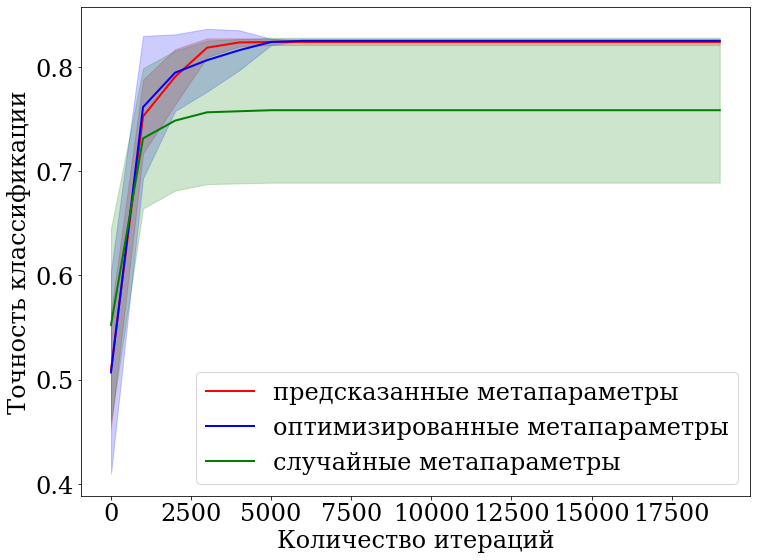

In [33]:
def plot_data(data, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    acc = np.array([subdata[i][1] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, acc.mean(1), '-', color=color, label=label)
    plt.fill_between(e, acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1), alpha=0.2, color=color)

plot_data(data_spline, 'предсказанные метапараметры', 'red')
plot_data(data_opt, 'оптимизированные метапараметры', 'blue')
plot_data(data_rand, 'случайные метапараметры', 'green')
plt.legend()
plt.xlabel('Количество итераций')
plt.ylabel('Точность классификации')
# plt.title('График зависимости точности классификации от\n номера итерации')
plt.savefig('acc_iter.pdf')
plt.show()

In [34]:
with open("exp3_linear_exp_splines_train_every_2.jsonl", "r") as read_file:
    data_spline2 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_train_every_3.jsonl", "r") as read_file:
    data_spline3 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_train_every_5.jsonl", "r") as read_file:
    data_spline5 = [json.loads(line) for line in read_file]
with open("exp3_linear_exp_splines_train_every_10.jsonl", "r") as read_file:
    data_spline10 = [json.loads(line) for line in read_file]

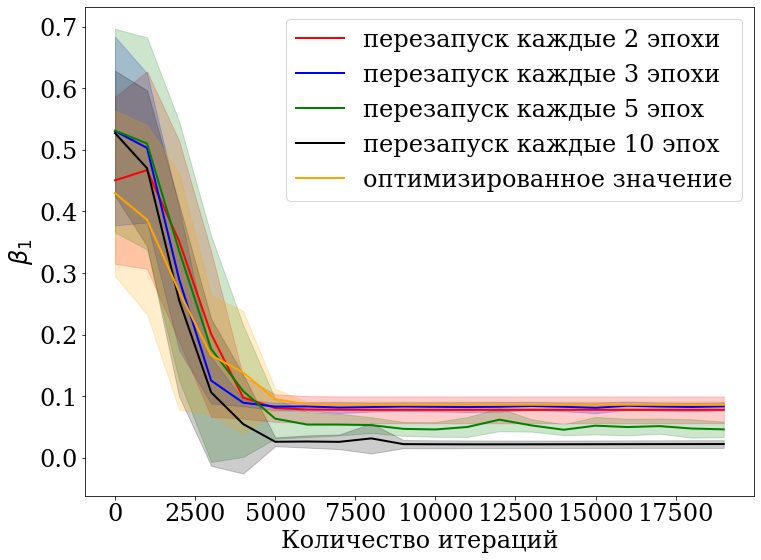

In [35]:
def plot_data_params(data, j, label, color):
    e = np.array([data[0][i][0] for i in range(len(data[0]))])
    par = np.array([subdata[i][j] for i in range(len(data[0])) for subdata in data]).reshape(e.shape[0], -1)
    plt.plot(e, par.mean(1), '-', color=color, label=label)
    plt.fill_between(e, par.mean(1)-par.std(1), par.mean(1)+par.std(1), alpha=0.2, color=color)

plot_data_params(data_spline2, 2, 'перезапуск каждые 2 эпохи', 'red')
plot_data_params(data_spline3, 2, 'перезапуск каждые 3 эпохи', 'blue')
plot_data_params(data_spline5, 2, 'перезапуск каждые 5 эпох', 'green')
plot_data_params(data_spline10, 2, 'перезапуск каждые 10 эпох', 'black')
plot_data_params(data_opt, 2, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_1$')
# plt.title(r'График зависимости значения $\beta_1$ от номера итерации')
plt.legend()
plt.savefig('beta1_iter.pdf')
plt.show()

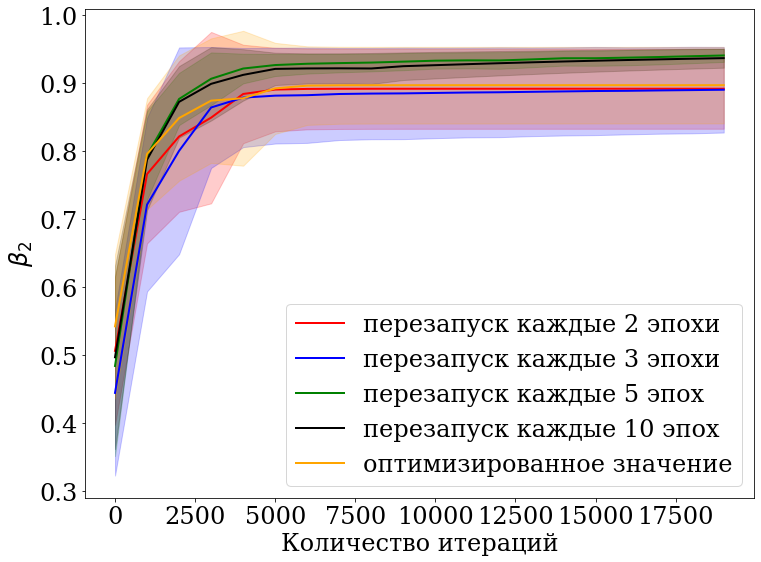

In [36]:
plot_data_params(data_spline2, 3, 'перезапуск каждые 2 эпохи', 'red')
plot_data_params(data_spline3, 3, 'перезапуск каждые 3 эпохи', 'blue')
plot_data_params(data_spline5, 3, 'перезапуск каждые 5 эпох', 'green')
plot_data_params(data_spline10, 3,'перезапуск каждые 10 эпох', 'black')
plot_data_params(data_opt, 3, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$\beta_2$')
# plt.title(r'График зависимости значения $\beta_2$ от номера итерации')
plt.legend()
plt.savefig('beta2_iter.pdf')
plt.show()

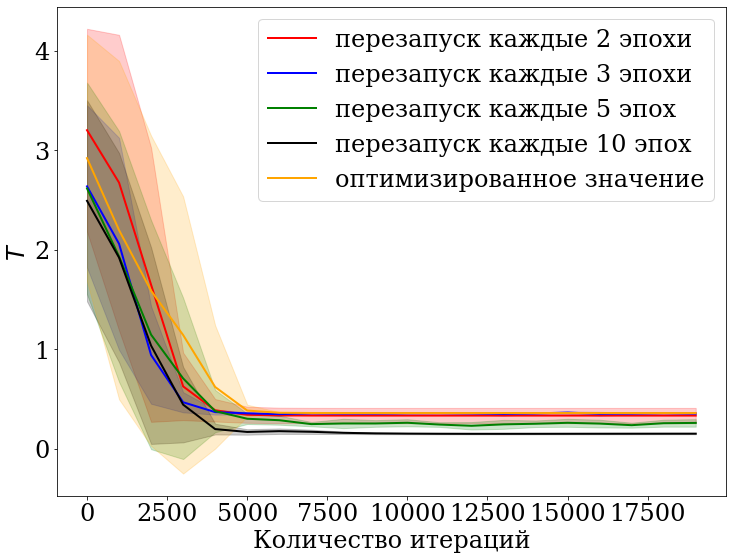

In [37]:
plot_data_params(data_spline2, 4, 'перезапуск каждые 2 эпохи', 'red')
plot_data_params(data_spline3, 4, 'перезапуск каждые 3 эпохи', 'blue')
plot_data_params(data_spline5, 4, 'перезапуск каждые 5 эпох', 'green')
plot_data_params(data_spline10, 4, 'перезапуск каждые 10 эпох', 'black')
plot_data_params(data_opt, 4, 'оптимизированное значение', 'orange')
plt.xlabel('Количество итераций')
plt.ylabel(r'$T$')
# plt.title(r'График зависимости значения $T$ от номера итерации')
plt.legend()
plt.savefig('temp_iter.pdf')
plt.show()